In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp
from functions import loc2data, get_rand_locs, loc2amplitude
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord
from astropy import units as u
import pandas as pd

# Coordinate Conversion

I think the below works, but I haven't found a database of J2000 Ra Dec coordinates with the corresponding Galactic coordinates, so I haven't tested thoroughly.

In [2]:
loc = [np.pi / 2, 0]
lon, lat = loc
eq = SkyCoord(lon, lat, unit='rad') # assumes input is in radians: otherwise unit='deg'
l, b = eq.galactic.l.value, eq.galactic.b.value
print(eq)
print(l, b)
print(eq.galactic)

<SkyCoord (ICRS): (ra, dec) in deg
    (90., 0.)>
206.98913107543058 -11.424490966989572
<SkyCoord (Galactic): (l, b) in deg
    (206.98913108, -11.42449097)>


In [3]:
circumstellar_disks = pd.read_excel('skymaps/circumstellar_disks.xlsx')
data = circumstellar_disks.loc[0, ["Object", "RA (J2000)", "DEC (J2000)"]]
data

Object         2MASSI J1628137-243139
RA (J2000)                16 28 13.70
DEC (J2000)               -24 31 39.0
Name: 0, dtype: object

In [4]:
nside = 1024
data_ra = data.loc["RA (J2000)"]
data_dec = data.loc["DEC (J2000)"]
coords = SkyCoord(data_ra, data_dec, unit=(u.hourangle, u.deg))
print(coords)
print(coords.galactic)

<SkyCoord (ICRS): (ra, dec) in deg
    (247.05708333, -24.5275)>
<SkyCoord (Galactic): (l, b) in deg
    (353.25218251, 16.52071255)>


This doesn't seem necessary but is interesting

In [5]:
healpix = HEALPix(nside=nside, order='nested', frame="galactic")
print(healpix.skycoord_to_healpix(coords))

5130363


In [6]:
rotator = hp.Rotator(coord=["C", "G"])
print(loc)
print(rotator(loc))

[1.5707963267948966, 0]
[2.62128473 1.68140255]


# Injection

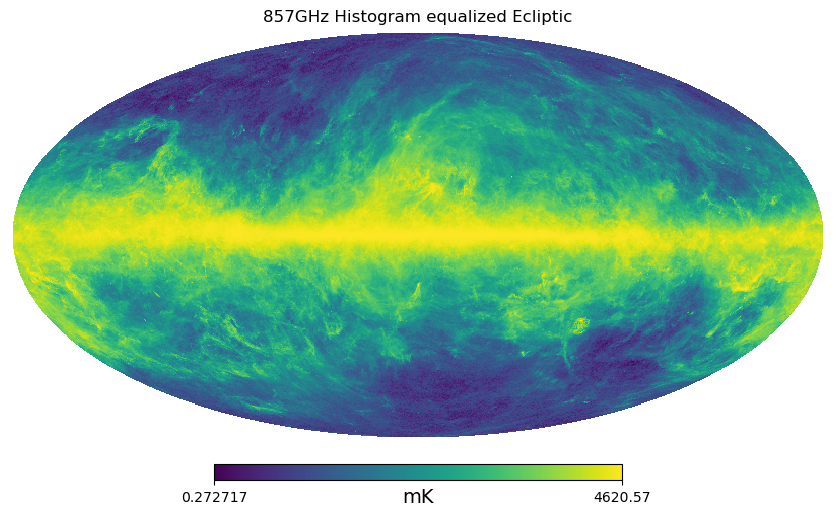

In [7]:
m_857 = hp.read_map("skymaps/HFI_SkyMap_857_2048_R1.10_nominal.fits")
nside = 1024
m_857 = hp.ud_grade(m_857, nside)
hp.mollview(
    m_857,
    #coord=["G", "E"],
    title="857GHz Histogram equalized Ecliptic",
    unit="mK",
    norm="hist",
)

## Signal Injection into one pixel

In [8]:
map_array = np.copy(m_857)
circ_radius = np.pi / 200
cutout_radius = -1
num_locs = 3

loc_list = get_rand_locs(num_locs, sphere_distr=True)

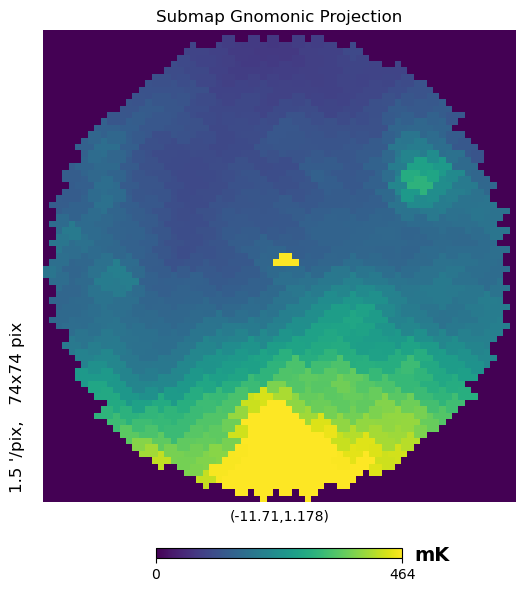

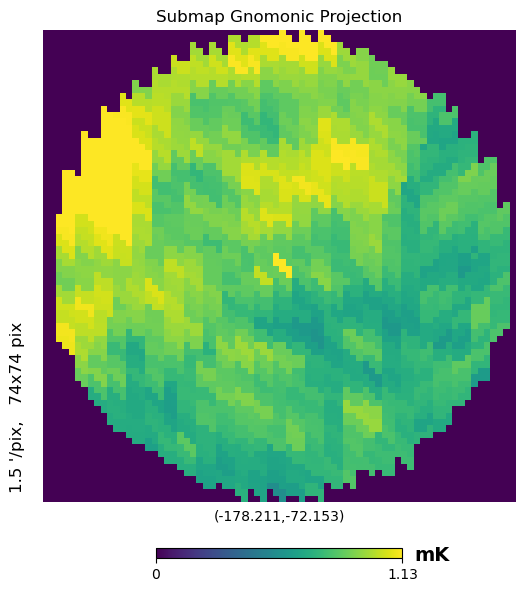

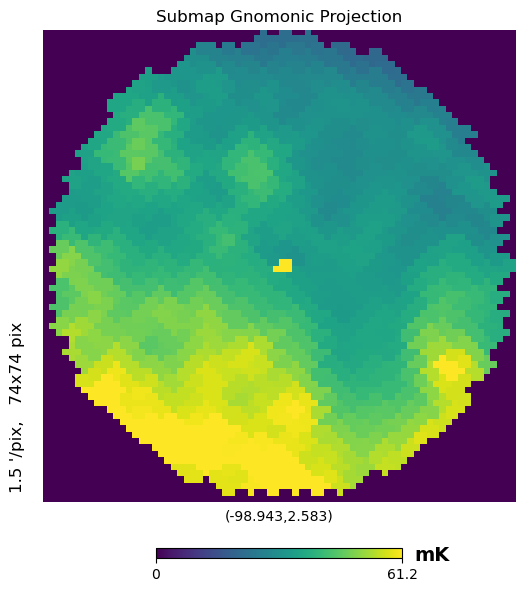

In [9]:
data_arrays = []
amplitude_arrays = []
signal = 1000
for loc in loc_list:
    loc_deg = np.rad2deg(loc)
    loc_pix = hp.ang2pix(nside, *loc_deg, lonlat=True)
    map_array[loc_pix] += signal
    data_arrays.append(loc2data(map_array, loc, circ_radius,
                                cutout_radius, show_gnomview=True))

## Annulus signal estimates of the locations above.

In [10]:
cutout_radius = -1

for loc in loc_list:
    loc_deg = np.rad2deg(loc)
    loc_pix = hp.ang2pix(nside, *loc_deg, lonlat=True)
    original = m_857[loc_pix]
    annulus, actual = loc2amplitude(map_array, loc, circ_radius, cutout_radius)
    signal_guess = actual - annulus
    print(f"original: {original}. altered/actual: {actual}. signal: {signal}. ")
    print(f"annulus: {annulus}. signal_guess: {signal_guess}.")
    print(f"signal_error: {signal - signal_guess}.\n")

original: 151.4274139404297. altered/actual: 1151.4273681640625. signal: 1000. 
annulus: 211.0383250512347. signal_guess: 940.3890431128278.
signal_error: 59.610956887172165.

original: 0.7750836610794067. altered/actual: 1000.7750854492188. signal: 1000. 
annulus: 0.8698048524616301. signal_guess: 999.9052805967572.
signal_error: 0.09471940324283423.

original: 32.73297119140625. altered/actual: 1032.73291015625. signal: 1000. 
annulus: 41.39624226016184. signal_guess: 991.3366678960881.
signal_error: 8.663332103911898.



## Signal injection and retrieval at 1000 locations using loc2amplitude

In [11]:
num_locs = 1000
loc_list = get_rand_locs(num_locs, sphere_distr=True)

In [12]:
map_array = np.copy(m_857)
circ_radius = np.pi / 200
cutout_radius = 0
signal = 1000

data_arrays = []
amplitude_arrays = []
# signal injection
for loc in loc_list:
    loc_deg = np.rad2deg(loc)
    loc_pix = hp.ang2pix(nside, *loc_deg, lonlat=True)
    map_array[loc_pix] += signal

In [13]:
cutout_radius = -1 # need to find better way to pick one pixel

original_list = []
signal_guess_list = []

for loc in loc_list:
    loc_pix = hp.ang2pix(nside, *np.rad2deg(loc), lonlat=True)
    annulus, actual = loc2amplitude(map_array, loc, circ_radius, cutout_radius)
    original = m_857[loc_pix]
    signal_guess = actual - annulus
    original_list.append(original)
    signal_guess_list.append(signal_guess)

abs_error = np.array(signal_guess_list) - signal
relative_error = np.array(signal_guess_list) / signal - 1

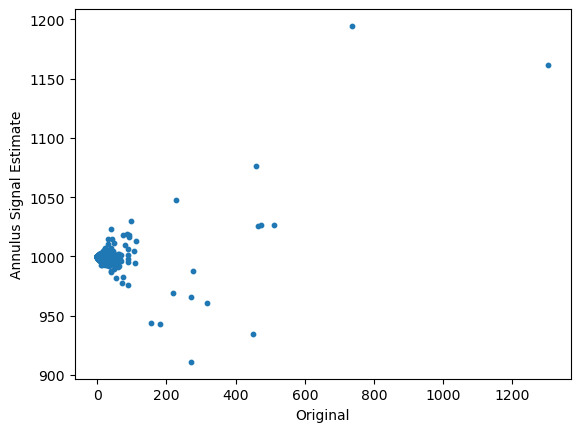

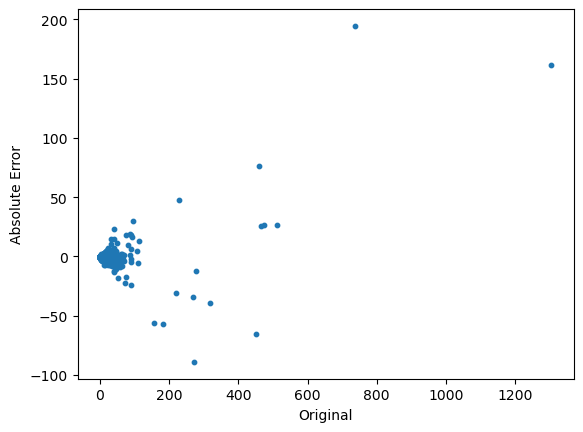

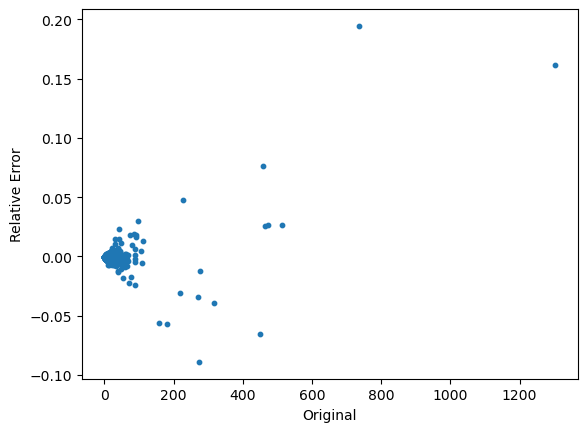

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel("Original")
ax.set_ylabel("Annulus Signal Estimate")
plt.scatter(original_list, signal_guess_list, s=10)

fig, ax = plt.subplots()
ax.set_xlabel("Original")
ax.set_ylabel("Absolute Error")
plt.scatter(original_list, abs_error, s=10)

fig, ax = plt.subplots()
ax.set_xlabel("Original")
ax.set_ylabel("Relative Error")
plt.scatter(original_list, relative_error, s=10)